# Project 3: Project #GetWellPlan
---

**Organization of Project Notebooks:**
- Notebook #1: [Problem Statement & Webscrapping](./01_problem_statement_and_webscrapping.ipynb)
- Notebook #2: [Data Cleaning & Exploratory Data Analysis](./02_data_cleaning_and_eda.ipynb)
- Notebook #3: [Preprocessing & Modelling](./03_preprocessing_and_modelling.ipynb)
- **Notebook #4: Sentiment Analysis & Recommendations** (current notebook)

## Notebook #4: Sentiment Analysis & Recommendations

### Contents
- [1. Introduction](#1.-Introduction)
- [2. Conducting a Sentiment Analysis](#2.-Conducting-a-Sentiment-Analysis)
- [3. Connecting the Top 20 Words with their Sentiments](#3.-Connecting-the-Top-20-Words-with-their-Sentiments)
- [4. Conclusion & Recommendations](#4.-Conclusion-&-Recommendations)
- [5. Limitations & Further Explorations](#5.-Limitations-&-Further-Explorations)

### 1. Introduction

In this notebook, we will be carrying out a Sentiment Analysis to determine the sentiment of the posts across both Walmart and Costco subreddits, to shed some insights on what customers and employees are saying about both brands on Reddit. 

In [44]:
# import the relevant packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, ImageColorGenerator
from textblob import TextBlob
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [45]:
# import the titles file
titles_df = pd.read_csv('datasets/titles.csv')

In [46]:
# view the top 5 rows
titles_df.head()

,Unnamed: 0,title,subreddit,title_lower,title_lemmatized
0,0,"If you're here, as a customer, to complain about absolutely anything; kindly, fuck off.",0,"if you're here, as a customer, to complain about absolutely anything; kindly, fuck off.",if you re here a a customer to complain about absolutely anything kindly fuck off
1,1,Weekly Salt Thread 207 - The Nintendo Switch NO! is never in stock,0,weekly salt thread 207 - the nintendo switch no! is never in stock,weekly salt thread the nintendo switch no is never in stock
2,2,How do y’all pay bills,0,how do y’all pay bills,how do y all pay bill
3,3,Just promoted myself to customer halfway through my first shift at a new store after transferring.,0,just promoted myself to customer halfway through my first shift at a new store after transferring.,just promoted myself to customer halfway through my first shift at a new store after transferring
4,4,DC Tips & Tricks #37: Make Sure Your Pallet Has a Strong Base of Sour Cream and Macaroni Salad,0,dc tips & tricks #37: make sure your pallet has a strong base of sour cream and macaroni salad,dc tip trick make sure your pallet ha a strong base of sour cream and macaroni salad


In [47]:
# create a separate DataFrame containing just 'subreddit' and 'lemmatized titles' for easier viewing
titles_lem_df = titles_df[['subreddit', 'title_lemmatized']]

In [48]:
# view the top 5 rows
titles_lem_df.head()

,subreddit,title_lemmatized
0,0,if you re here a a customer to complain about absolutely anything kindly fuck off
1,0,weekly salt thread the nintendo switch no is never in stock
2,0,how do y all pay bill
3,0,just promoted myself to customer halfway through my first shift at a new store after transferring
4,0,dc tip trick make sure your pallet ha a strong base of sour cream and macaroni salad


### 2. Conducting a Sentiment Analysis

For this section, we will be using the Sentiment Intensity Analyzer, to obtain the positive, neutral, negative and compounded scores for all the posts in Walmart and Costco subreddits. 

In [49]:
# Instantiate Sentiment Intensity Analyzer
sent = SentimentIntensityAnalyzer()

In [50]:
# obtain the polarity scores for each row in the DataFrame
titles_lem_df['compound'] = [sent.polarity_scores(x)['compound'] for x in titles_lem_df['title_lemmatized']]
titles_lem_df['neg'] = [sent.polarity_scores(x)['neg'] for x in titles_lem_df['title_lemmatized']]
titles_lem_df['neu'] = [sent.polarity_scores(x)['neu'] for x in titles_lem_df['title_lemmatized']]
titles_lem_df['pos'] = [sent.polarity_scores(x)['pos'] for x in titles_lem_df['title_lemmatized']]

In [51]:
# view the top 5 rows
titles_lem_df.head()

,subreddit,title_lemmatized,compound,neg,neu,pos
0,0,if you re here a a customer to complain about absolutely anything kindly fuck off,-0.4186,0.317,0.507,0.176
1,0,weekly salt thread the nintendo switch no is never in stock,-0.2960,0.180,0.820,0.000
2,0,how do y all pay bill,-0.1027,0.259,0.741,0.000
3,0,just promoted myself to customer halfway through my first shift at a new store after transferring,0.4215,0.000,0.833,0.167
4,0,dc tip trick make sure your pallet ha a strong base of sour cream and macaroni salad,0.7783,0.057,0.566,0.377


In [52]:
# view the mean compound, negative, neutral and positive scores by subreddit
titles_lem_df.groupby('subreddit')[['compound', 'neg', 'neu', 'pos']].mean()

,compound,neg,neu,pos
subreddit,,,,
0,0.017236,0.078235,0.832010,0.088673
1,0.109493,0.040811,0.859664,0.098503


- Based on the sentiment scores, we observe that: 
    - Walmart has obtained a mean compounded score of +1.7%, where:
        - Mean negative score: 7.8%
        - Mean neutral score: 83.2%
        - Mean positive score: 8.9%
    - Costco has obtained a mean compounded score of +10.9%, where:
        - Mean negative score: 4.1%
        - Mean neutral score: 86.0%
        - Mean positive score: 9.9%
        
        
- While majority of the posts fall within the neutral scoring range, it can be seen that Walmart has a higher mean negative score and lower mean positive score, when compared to Costco.
- For easier identification, we will introduce a sentiment label to identify whether the posts can be treated as negative, neutral, positive, based on their compounded scores.

In [53]:
# include a sentiment label where:
# compound score>=0.5 is positive
# compound score<=-0.5 is negative
# compound scores between -0.5 to 0.5 is neutral

def label(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'

# create a new column to store the sentiment label 
titles_lem_df['sentiment_label'] = titles_lem_df['compound'].apply(label)

In [54]:
# view the top 5 rows
titles_lem_df.head()

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
0,0,if you re here a a customer to complain about absolutely anything kindly fuck off,-0.4186,0.317,0.507,0.176,Neutral
1,0,weekly salt thread the nintendo switch no is never in stock,-0.2960,0.180,0.820,0.000,Neutral
2,0,how do y all pay bill,-0.1027,0.259,0.741,0.000,Neutral
3,0,just promoted myself to customer halfway through my first shift at a new store after transferring,0.4215,0.000,0.833,0.167,Neutral
4,0,dc tip trick make sure your pallet ha a strong base of sour cream and macaroni salad,0.7783,0.057,0.566,0.377,Positive


In [55]:
# view the breakdown of sentiment_label for Walmart posts
titles_lem_df[titles_lem_df['subreddit']==0]['sentiment_label'].value_counts(normalize=True)

Neutral     0.869048
Negative    0.066017
Positive    0.064935
Name: sentiment_label, dtype: float64

In [56]:
# view the breakdown of sentiment_label for Costco posts
titles_lem_df[titles_lem_df['subreddit']==1]['sentiment_label'].value_counts(normalize=True)

Neutral     0.818088
Positive    0.147996
Negative    0.033916
Name: sentiment_label, dtype: float64

Text(0.5, 1.0, 'Proportion of Sentiment Labels Distribution between Walmart (0) and Costco (1)')

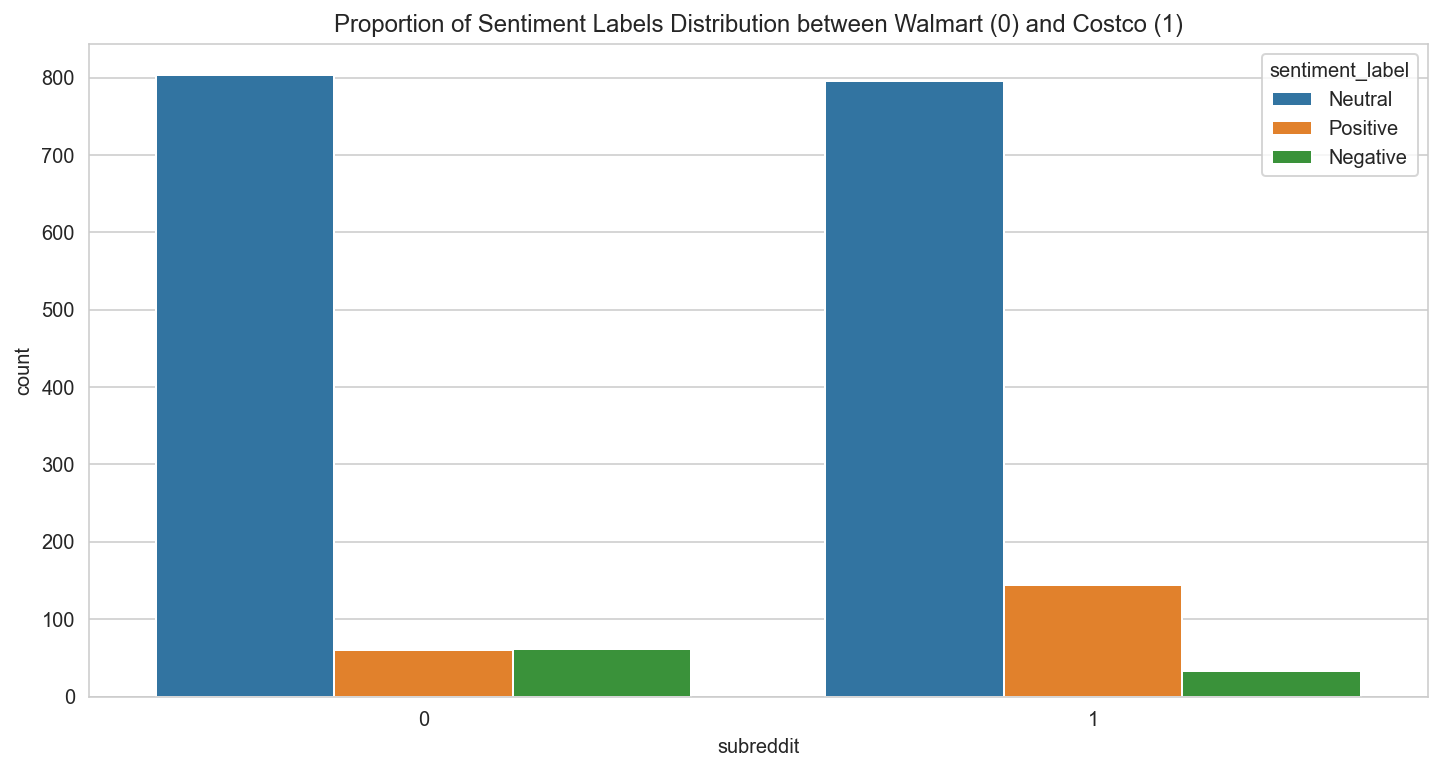

In [57]:
# plot a bar chart to view the count of positive, negative and neutral labels
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(data=titles_lem_df, x='subreddit', hue='sentiment_label', ax=ax)
plt.title('Proportion of Sentiment Labels Distribution between Walmart (0) and Costco (1)')

- With the sentiment labelling, we observe the following proportion of sentiment labels: 
    - For Walmart:
        - Proportion of negative posts: 6.6%
        - Proportion of neutral posts: 86.9% 
        - Proportion of positive posts: 6.5%
    - For Costco: 
        - Proportion of negative posts: 3.4% 
        - Proportion of neutral posts: 81.8%
        - Proportion of positive posts: 14.8%

- We see a greater proportion of positive posts in Costco - more than two times that of Walmart's. 
- We also notice a strikingly higher proportion of negative posts in Walmart, as compared to Costco.

### 3. Connecting the Top 20 Words with their Sentiments

In this section, we will look into the posts containing the top 20 words that identify whether a post belongs to Walmart and Costco, in relation to whether they are labelled with positive or negative sentiment.


**Examining top words for Walmart**

- We will first examine the posts containing the top 10 words that identify whether a post belongs to **Walmart** (in the order of increasing importance) and their respective sentiments: 'loa', 'vaccine', 'lol', 'covid', 'ppto', 'getting', 'pallet', 'store', 'associate', 'customer'.
    - Particularly, we will look into these words:
        - 'customer'
        - 'associate'
        - 'store'
        - 'getting'
        - 'covid'
        - 'vaccine'
        - 'lol'

In [58]:
# adjust the column width to view the full text in the dataframe
pd.set_option("display.max_colwidth", -1)

In [59]:
# create a variable featuring just Walmart posts
wal_lem_df = titles_lem_df[(titles_lem_df['subreddit']==0)]

# view the new variable created
wal_lem_df.head()

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
0,0,if you re here a a customer to complain about absolutely anything kindly fuck off,-0.4186,0.317,0.507,0.176,Neutral
1,0,weekly salt thread the nintendo switch no is never in stock,-0.2960,0.180,0.820,0.000,Neutral
2,0,how do y all pay bill,-0.1027,0.259,0.741,0.000,Neutral
3,0,just promoted myself to customer halfway through my first shift at a new store after transferring,0.4215,0.000,0.833,0.167,Neutral
4,0,dc tip trick make sure your pallet ha a strong base of sour cream and macaroni salad,0.7783,0.057,0.566,0.377,Positive


**i) Examine the top words for Walmart: 'customer'**

In [60]:
# view the negative posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Negative')][wal_lem_df['title_lemmatized'].str.contains('customer')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
10,0,worst type of customer in ogp doesn t check in doesn t call when they get here if we re not busy i usually make them sit there for a couple minute,-0.6249,0.132,0.868,0.000,Negative
682,0,i swear nearly every customer who hate self checkout ha a hive mind i can t tell you how many customer i ve heard say this kind of stuff reek of entitlement,-0.7096,0.246,0.682,0.071,Negative
823,0,here a both customer and former slave i hate the workplace assessment,-0.5719,0.291,0.709,0.000,Negative


In [61]:
# view the positive posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Positive')][wal_lem_df['title_lemmatized'].str.contains('customer')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
365,0,gotta love our customer,0.6369,0.0,0.417,0.583,Positive
745,0,what s been some of your greatest hit customer story recently,0.6369,0.0,0.682,0.318,Positive
877,0,promoted myself to customer everyone still employed by wally world good luck,0.8271,0.0,0.508,0.492,Positive


**ii) Examine the top words for Walmart: 'associate'**

In [62]:
# view the negative posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Negative')][wal_lem_df['title_lemmatized'].str.contains('associate')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
120,0,any other former associate hate shopping at walmart,-0.5719,0.346,0.654,0.000,Negative
387,0,any other ogp associate just hate doordash driver,-0.5719,0.346,0.654,0.000,Negative
508,0,hypersensitive team lead worry no one like them so they repeatedly fuck over the associate who actually respected them,-0.5046,0.311,0.492,0.197,Negative
760,0,doe walmart hate america if they make associate work on july th,-0.5719,0.252,0.748,0.000,Negative


In [63]:
# view the positive posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Positive')][wal_lem_df['title_lemmatized'].str.contains('associate')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
860,0,ha your store raised the pay to an hour for the stocker and ogp associate like mine did,0.5423,0.066,0.704,0.230,Positive
907,0,announcement that associate would love to hear over the pa system,0.6369,0.000,0.704,0.296,Positive
911,0,is fresh food store associate dairy and frozen product a good position for me,0.6369,0.000,0.679,0.321,Positive


**iii) Examine the top words for Walmart: 'store'**

In [64]:
# view the negative posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Negative')][wal_lem_df['title_lemmatized'].str.contains('store')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
160,0,my deli department at my store is missing basically every cleaning tool we should have a per the diagram on the wall i ve received zero training who to contact to fix the problem,-0.5994,0.140,0.860,0.0,Negative
188,0,i stopped an osha violation from closing our store down other person omg how me self control,-0.6249,0.267,0.733,0.0,Negative
280,0,i work at what store currently going through an identity crisis,-0.6249,0.313,0.687,0.0,Negative


In [65]:
# view the negative posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Positive')][wal_lem_df['title_lemmatized'].str.contains('store')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
390,0,so stoked my store got this in im a huge hot pepper lover,0.7269,0.000,0.621,0.379,Positive
569,0,today wa my last day at my store since i m moving on to a better position and me and my manager said a tearful goodbye it s hard saying bye to great manager coworkers i m still sad about it,0.5423,0.108,0.723,0.169,Positive
771,0,walmart to give u s store worker free samsung phone,0.5106,0.000,0.680,0.320,Positive
860,0,ha your store raised the pay to an hour for the stocker and ogp associate like mine did,0.5423,0.066,0.704,0.230,Positive
911,0,is fresh food store associate dairy and frozen product a good position for me,0.6369,0.000,0.679,0.321,Positive


**iv) Examine the top words for Walmart: 'getting'**

In [66]:
# view the negative posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Negative')][wal_lem_df['title_lemmatized'].str.contains('getting')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
517,0,seasonal tl getting shit for wearing short,-0.5574,0.375,0.625,0.0,Negative
687,0,after getting fired from walmart how long would i have to wait before i can be hired at a different location,-0.5574,0.175,0.825,0.0,Negative


In [67]:
# view the negative posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Positive')][wal_lem_df['title_lemmatized'].str.contains('getting')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
396,0,when only one person in the department care about getting claim done you get a table like this,0.6908,0.0,0.725,0.275,Positive


**v) Examine the top words for Walmart: 'covid'**

In [68]:
# view the negative posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Negative')][wal_lem_df['title_lemmatized'].str.contains('covid')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
352,0,how doe calling off the day after you get a covid shot work my co worker said he wa not pointed and that it wa paid for i m already at point with no time available so i don t want to get fired,-0.6395,0.134,0.830,0.036,Negative
559,0,failing the assessment after covid shot,-0.5106,0.398,0.602,0.000,Negative


In [69]:
# view the positive posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Positive')][wal_lem_df['title_lemmatized'].str.contains('covid')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
637,0,another round of covid bonus,0.5423,0.000,0.533,0.467,Positive
830,0,yet another question about loa went to extend time for covid leave caring for family member who ha had covid,0.7269,0.049,0.653,0.298,Positive


**vi) Examine the top words for Walmart: 'lol'**

In [70]:
# view the negative posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Negative')][wal_lem_df['title_lemmatized'].str.contains('lol')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label


In [71]:
# view the positive posts for Walmart
wal_lem_df[(wal_lem_df['sentiment_label']=='Positive')][wal_lem_df['title_lemmatized'].str.contains('lol')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
239,0,fun time at work yesterday lol not really,0.7269,0.000,0.496,0.504,Positive
283,0,lol the comment section regarding fbi offering reward instead of walmart for arson suspect,0.6486,0.112,0.558,0.330,Positive
305,0,i find these funny lol,0.6908,0.000,0.260,0.740,Positive
873,0,nice try homeoffice lol,0.6808,0.000,0.263,0.737,Positive


**Initial thoughts on Walmart:**
- Based on the above positive and negative posts while examining the top words for Walmart, it can be observed that:
    - A number of associates have been taking to Reddit to rant about the customers’ behaviour publicly - mainly voicing their frustrations.
    - Some associates are not too fond of their working hours and working structure, citing reasons like working during public holidays and having team leads that are irresponsible. 
    - There have been some queries regarding covid leave – i.e. whether the COVID-19 leave is being paid for by the company or not. 
- However, in spite of the rants, initiatives like raising the pay for associates, giving of Samsung phones and having COVID-19 bonus do keep them satisfied and willing to work for Walmart. 



**Linking back to our earlier research on initiatives that have been introduced by Walmart:**
- We have learnt that a **team-based operating model** was introduced in Walmart in May 2019, where small teams of associates were created, cross-trained, and given more ownership of their work. (Source: [Serenah McKay (May 2019)](https://www.arkansasonline.com/news/2019/may/03/walmart-tests-new-work-hierarchy-201905/))
    - Yet, some employees have criticized that the new operating model will not address issues faced by associates receiving hourly wages, most notably part-timers at Walmart who may not be clocking sufficient work hours. The employees have shared their preference for Walmart to provide "livable wage and enough hours". (Source: [Serenah McKay (May 2019)](https://www.arkansasonline.com/news/2019/may/03/walmart-tests-new-work-hierarchy-201905/))
    - Similarly, Walmart has also been pinpointed to lag behind in its minimum hourly wage (USD 11/hour) as compared to other supermarkets such as Costco (USD 16/hour) and Amazon (USD 15/hour). It is currently undergoing a revision of its employee structure, where it aims to move more of its employees to full-time (2/3 of its stores' hourly jobs) by early 2022. (Source: [CNBC (April 2021)](https://www.cnbc.com/2021/04/14/walmart-makes-more-workers-full-time-in-effort-to-retain-employees.html))


- We have seen that a **COVID-19 emergency leave policy** was introduced in March 2020, where full-time and part-time associates would receive up to two weeks of salary should they be required to stay home for COVID-19 related reasons. Absences during this period of time would not be counted against attendance, and additional pay replacement (up to 26 weeks) would be provided if associated have yet to recover. (Source: [John Furner (March 2020)](https://corporate.walmart.com/newsroom/2020/03/10/new-covid-19-policy-to-support-the-health-of-our-associates)) 
    - Yet, some employees still have queries regarding what this benefit comprises, and are afraid that their absences will be counted against their attendance.


- It is heartwarming to know that **more than USD 700 million in additional cash bonuses** were distributed to its U.S.-based associates (both full-time and part-time employees) in December 2020, in recognition of their commitment to customers during the COVID-19 pandemic. (Source: [Walmart Corporate (December 2020)](https://corporate.walmart.com/newsroom/2020/12/03/walmart-announces-more-than-700-million-in-additional-associate-bonuses-tops-2-8-billion-in-total-cash-bonuses-to-associates-in-2020))

**Examining top words for Costco**

- We will next examine the posts containing the top 10 words that identify whether a post belongs to **Costco** (in the order of increasing importance) and their respective sentiments: 'experience', 'anyone', 'online', 'good', 'delivery', 'best', 'pizza', 'food', 'membership', 'chicken'. 
    - Particularly, we will look into these words:
        - 'chicken'
        - 'membership'
        - 'food'
        - 'best'
        - 'delivery'

In [72]:
# create a variable featuring just Costco posts
cos_lem_df = titles_lem_df[(titles_lem_df['subreddit']==1)]

# view the new variable created
cos_lem_df.head()

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
924,1,always use your best judgement before buying a product displayed on this subreddit,0.6369,0.0,0.724,0.276,Positive
925,1,please welcome our new moderator,0.6486,0.0,0.361,0.639,Positive
926,1,costco seems like a nice place daughter tweet about dad who want to work for costco after being laid off during covid,0.6808,0.0,0.732,0.268,Positive
927,1,loving this dog bed she wa out cold minute after laying in it,0.5994,0.0,0.755,0.245,Positive
928,1,watching member pick out chicken,0.0000,0.0,1.000,0.000,Neutral


**i) Examine the top words for Costco: 'chicken'**

In [73]:
# view the negative posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Negative')][cos_lem_df['title_lemmatized'].str.contains('chicken')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
1658,1,woody harrelson expose shocking treatment of costco chicken,-0.5106,0.417,0.583,0.0,Negative


In [74]:
# view the positive posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Positive')][cos_lem_df['title_lemmatized'].str.contains('chicken')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
937,1,rana tagliatelle grilled white chicken portobello mushroom sauce found in woodbridge va so good would definitely buy again,0.7721,0.000,0.705,0.295,Positive
1070,1,i m not a big frozen food person but these bacon wrapped chicken breast are soooo good bonus pic of the rest of my haul,0.8625,0.000,0.699,0.301,Positive
1149,1,ha anyone tried the korean bbq flavored chicken wing any good,0.6486,0.000,0.629,0.371,Positive
1222,1,used a nordicware griddle from costco on my solo stove ranger wa searching for something just like that to cook over my solo stove didn t want a grate to prevent food grease from falling into the stove i waited until the wood fire burnt down into hot coal chicken wa amazing did burger too,0.5719,0.069,0.780,0.151,Positive
1451,1,alot of small chicken bone in this burger i tried two it like they straight up ground up a whole chicken with bone n all beware,0.5267,0.000,0.827,0.173,Positive
1463,1,wow the price of chicken sure ha gone up,0.8176,0.000,0.414,0.586,Positive


**ii) Examine the top words for Costco: 'membership'**

In [75]:
# view the negative posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Negative')][cos_lem_df['title_lemmatized'].str.contains('membership')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label


In [76]:
# view the positive posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Positive')][cos_lem_df['title_lemmatized'].str.contains('membership')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
1114,1,doe costco have a virtual membership card like sam s club like we re you can add it to your iphone wallet,0.6124,0.0,0.783,0.217,Positive
1179,1,costco reimburses executive membership fee if my reward is le than,0.5719,0.0,0.730,0.270,Positive
1719,1,newer employee here what do i need to bring to a costco store to get the free membership,0.5106,0.0,0.820,0.180,Positive


**iii) Examine the top words for Costco: 'food'**

In [77]:
# view the negative posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Negative')][cos_lem_df['title_lemmatized'].str.contains('food')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label


In [78]:
# view the positive posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Positive')][cos_lem_df['title_lemmatized'].str.contains('food')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
1070,1,i m not a big frozen food person but these bacon wrapped chicken breast are soooo good bonus pic of the rest of my haul,0.8625,0.000,0.699,0.301,Positive
1222,1,used a nordicware griddle from costco on my solo stove ranger wa searching for something just like that to cook over my solo stove didn t want a grate to prevent food grease from falling into the stove i waited until the wood fire burnt down into hot coal chicken wa amazing did burger too,0.5719,0.069,0.780,0.151,Positive
1538,1,local food bank praise yrs donation,0.5574,0.000,0.581,0.419,Positive
1609,1,this ain t it kev the picture make it look so much better than in reality it taste like very tough over peppered beef jerky the korean bbq sauce taste like it wa made by someone who s never had korean food before bulgogi or kalbi and only had access to a maximum security prison kitchen,0.6689,0.081,0.750,0.169,Positive
1858,1,when will costco start permitting the return of food and or health and beauty product,0.5859,0.000,0.787,0.213,Positive
1872,1,happy to find wet cat food today for can,0.5719,0.000,0.684,0.316,Positive


**iv) Examine the top words for Costco: 'best'**

In [79]:
# view the negative posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Negative')][cos_lem_df['title_lemmatized'].str.contains('best')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label


In [80]:
# view the positive posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Positive')][cos_lem_df['title_lemmatized'].str.contains('best')].head()

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
924,1,always use your best judgement before buying a product displayed on this subreddit,0.6369,0.0,0.724,0.276,Positive
955,1,where can i give the best compliment looking for an employee response if possible,0.8074,0.0,0.601,0.399,Positive
960,1,i thought kerrygold wa the best butter costco had to offer until i found this last week,0.6369,0.0,0.769,0.231,Positive
1048,1,best time to get the best deal on an ipad,0.8555,0.0,0.488,0.512,Positive
1082,1,best frozen lunch for work,0.6369,0.0,0.488,0.512,Positive


**v) Examine the top words for Costco: 'delivery'**

In [81]:
# view the negative posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Negative')][cos_lem_df['title_lemmatized'].str.contains('delivery')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
988,1,anyone else have any bad experience with tv delivery through costco,-0.5423,0.259,0.741,0.000,Negative
1838,1,costco com innovel fail this is the th appointment for delivery let s see if they show up this time no show so far no phone call or email saying it s cancelled i have to call and wait on hold every time costco s response yeah we have a lot of complaint about delivery,-0.8360,0.208,0.755,0.038,Negative


In [82]:
# view the positive posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Positive')][cos_lem_df['title_lemmatized'].str.contains('delivery')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
1893,1,looking for a treadmill doe costco offer free delivery and assembly,0.5106,0.0,0.732,0.268,Positive


**vi) Examine the top words for Costco: 'experience'**

In [83]:
# view the negative posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Negative')][cos_lem_df['title_lemmatized'].str.contains('experience')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
988,1,anyone else have any bad experience with tv delivery through costco,-0.5423,0.259,0.741,0.0,Negative
1741,1,worst costco experience,-0.6249,0.672,0.328,0.0,Negative


In [84]:
# view the positive posts for Costco
cos_lem_df[(cos_lem_df['sentiment_label']=='Positive')][cos_lem_df['title_lemmatized'].str.contains('experience')]

,subreddit,title_lemmatized,compound,neg,neu,pos,sentiment_label
1755,1,costco tire center totally amazing experience,0.6240,0.0,0.55,0.45,Positive
1852,1,ha anyone bought a diamond ring or diamond jewelry from costco store or online how wa the experience,0.7351,0.0,0.66,0.34,Positive


**Initial thoughts on Costco:**
- Based on the above positive and negative posts while examining the top words for Costco, it can be observed that:
    - Majority of customers visiting Costco enjoy the food sold at the supermarkets, specifically frozen food like frozen cooked chicken that provide convenience when working from home. 
    - There are some queries regarding the Costco membership, their requirements and perks. 
    - Overall, there are fewer negative posts containing the top words for Costco, as compared to those of Walmart, though there are the occasional complaints about the inefficient delivery services. 


**Linking back to our earlier research on what makes Costco stand out:**
- Costco's business model as a 'warehouse club' allows it to sell a variety of **wholesales items in bulk** directly to customers who have registered for its membership (paying a minimum of USD 60/year), keeping the costs low with wholesale prices. (Source: [Henry Bewicke (May 2021)](https://www.talon.one/blog/what-we-can-learn-from-costcos-promotion-strategy))
    - Particularly, in the COVID-19 pandemic, customers are looking to purchase bulk items to maximise their cost savings, as well as recoup their membership fee. This includes necessities such as toilet paper, paper towels, water, rice, disinfectant wipes, etc. (Source: [Alexandra Ossola & Marc Bain (May 2021)](https://qz.com/2013986/costco-is-proof-that-in-store-shopping-is-far-from-over/))
    - Customers have also shared that the benefits embedded in the membership keep them going back to Costco, and that include travel vouchers, grocery discounts, free health screenings, etc., which increase their brand loyalty. (Source: [Brooke Sager (October 2020)](https://www.eatthis.com/costco-shoppers-obsessed/))


- We have learnt that Costco is known for its **food** - particularly its **food court** which features the quarter pound hot dog and refillable drink for just USD 1.50, and rotisseries chicken for USD 4.99. (Source: [Henry Bewicke (May 2021)](https://www.talon.one/blog/what-we-can-learn-from-costcos-promotion-strategy)).
    - However, during the COVID-19 pandemic, most customers would turn to purchasing staples in bulk from the stores, such as as dairy, bread, proteins, canned food and sauces, as these foods can be stored in the freezer or remain shelf-stable for a long period of time (Source: [Brooke Sager (October 2020)](https://www.eatthis.com/costco-shoppers-obsessed/)). This provides convenience to customers who are fully occupied while working from home, for they need not head to the stores frequently, and yet still able to prepare delicious meals by heating up frozen store-bought food.  

### 4. Conclusion & Recommendations

We started with the **primary objective** to understand Walmart's brand image on Reddit, in comparison to Costco's, so as to introduce a series of strategies for improvement.

- Yet, it turns out that our associates at the stores are sharing their frustrations about the company and customers on Reddit, which will negatively affect our brand image online.
- In “The State of the American Workplace” report by Gallup, it states that employees who are engaged are more likely to improve customer relationships, with a resulting 20% increase in sales. (Source: [Shep Hyken (May 2017]( https://www.forbes.com/sites/shephyken/2017/05/27/how-happy-employees-make-happy-customers/?sh=113bc7035c35))
- Since happy employees make happy customers, it is crucial that we first look into the current employee experience and address areas that might have been overlooked.
- With happy employees, we will be able to observe positive changes to Walmart's brand image on Reddit. 
    
 
- **Our recommendations include**:
    1. Store Managers and/or Team Leads can address misconceptions that associates may have regarding COVID-19 leave, which include:
        - The 2-week COVID-19 leave is being paid for by the company; 
        - Associates who are absent because of COVID-19 related reasons will not have their attendance penalised.   
    2. Human Resource Team, Store Managers and/or Team Leads can conduct monthly or quarterly surveys for associates to provide their feedback about the working environment, working structure, salary and benefits, new team-based operating model, etc.  
    3. Human Resource Team can conduct a thorough review of the employees' compensation and benefits packages, to identify aspects that can be improved so as to provide competitive wages and benefits for associates.
    4. Human Resource Team can reinforce the fact that associates are able to [report a concern online](https://www.walmartethics.com/content/walmartethics/en_us/report-a-concern.html) without their identities being exposed, especially if they have Team Leads and/or Store Managers who are not carrying out the necessary duties.


We then look into the **secondary objective**, which is to identify positive and negative feedback from Reddit users regarding both supermarkets, where positive feedback will be reinforced and/or implemented, while negative feedback can be addressed and prevented. 

- Since majority of the Walmart posts are shared by the employees, we will identify some of the best practices from Costco that can be potentially introduced in Walmart. 


- **Our recommendations include**: 
    1. We can engage the Product Team to look at introducing bulk items into the stores, particularly for basic necessities such as toilet paper, paper towels, water, staples like dairy and bread, proteins, disinfectant wipes, etc., and price the items at their wholesale prices. This will also allow cost savings to be passed over to customers, which is especially crucial during this pandemic. 
        - Alternatively, we can engage the Marketing Team can focus on ramping up marketing efforts for Sam's Club, which is its membership-only retail warehouse clubs that offer lower-priced warehouse products to customers. 
    2. We can also engage the Product Team to consider introducing items that provide convenience while customers are working from home, such as ready-cooked meals - the focus will be on bringing in a variety of good-quality food products to the stores, so that our customers will be spoilt for choices, and keeps them coming back for more. 
    3. Under the Walmart+ membership, apart from providing free delivery/shipping of items, selection of medical prescriptions, savings on fuel and mobile scan & go functions, we can engage the Rewards Team to look at providing discounts and rebates to members who are frequent shoppers at the stores, so as to enhance customer loyalty. (Source: [Walmart (2021)](https://www.walmart.com/plus/benefits)) 
    4. We should continue providing our curbside grocery pickup services, which provides convenience to customers who choose to pick up their items. (Source: [James Brumley (April 2021)](https://www.fool.com/investing/2021/04/11/better-buy-costco-vs-walmart/)). In addition, we should maintain our low price subscription-based grocery delivery services, as any price increase may create setbacks that prompt other grocery stores to look for alternative channels for delivery services. 
    5. In terms of building connection with customers via our brand, we can engage the Marketing Team to look at crafting marketing messages that can match the emotional tenor that our customers are experiencing during this COVID-19 pandemic. This includes messages that convey comfort, relief and hope, so as to reduce the feelings of loneliness and fear that our customers may have, and demonstrating that Walmart is here as a partner committed to helping them overcome the tough times. (Source: [Anjali Lai (March 2020)](https://go.forrester.com/blogs/consumer-energy-drops-on-all-four-dimensions-amid-covid-19/#utm_source=pr_pitch&utm_medium=pr&utm_campaign=covid19&utm_content=ConsumerEnergyIndex))

### 5. Limitations & Further Explorations

While we have developed a classification model (using Logistic Regression and TF-IDF Vectorizer) that has allowed us to achieve an accuracy score of 78.1%, some of the **limitations** in this project includes: 
1. **Access to real-time data extraction**: As users are constantly sharing new posts on Reddit, it is crucial that we can extract the latest posts to understand how users’ impression of the supermarkets have changed overtime.
2. **Access to a bigger corpus**: While we have analysed a total of 1897 posts across both Walmart and Costco subreddits, it may be more ideal to obtain a bigger corpus for analysis, so as to expand on our range of vocabulary words regarding users' opinions.  

Moving forward, we can looking at **improving the model performance and recommendations** with the following initiatives: 
1. Incorporating other features such as scores, number of comments, character length and word count of titles in the model.
2. Combining the posts in the 'self-text' column with 'title' column in the current dataset, so as to increase the range of vocabulary words.  
3. Extracting the comments from other users on the post titles, to not just increase the corpus size but to derive the sentiments of those comments.  
4. Create Word2Vec word vectors to understand the relationship between the words in a post. 